# **1. 라이브러리 불러오기**

In [ ]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# **2. 데이터 불러오기 및 간단 EDA**

In [ ]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')
#주의: baseline에서는 validation_sample을 사용하지 않았습니다.

In [ ]:
print(train.shape, test.shape, submission.shape)

(472972, 3) (1418916, 2) (1418916, 2)


In [ ]:
train.head()

,id,level,full_log
0,0,0,"Sep 24 10:02:22 localhost kibana: {""type"":""err..."
1,1,0,Feb 8 16:21:00 localhost logstash: [2021-02-0...
2,2,0,"Jan 13 01:50:40 localhost kibana: {""type"":""err..."
3,3,0,"Jan 4 10:18:31 localhost kibana: {""type"":""err..."
4,4,1,type=SYSCALL msg=audit(1603094402.016:52981): ...


In [ ]:
#test는 level값이 없습니다
test.head()

,id,full_log
0,1000000,"Feb 8 15:47:26 localhost kibana: {""type"":""err..."
1,1000001,"Sep 24 03:46:39 localhost kibana: {""type"":""err..."
2,1000002,type=SYSCALL msg=audit(1611888200.428:210563):...
3,1000003,"Jan 18 11:24:06 localhost kibana: {""type"":""err..."
4,1000004,type=SYSCALL msg=audit(1603081202.050:46851): ...


<AxesSubplot:>

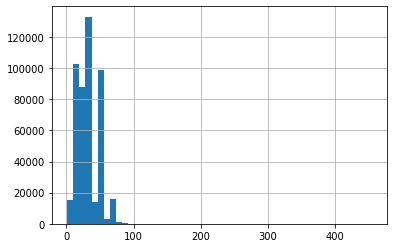

In [ ]:
#train full_log의 길이 확인
train['full_log'].str.split(' ').str.len().hist(bins=50)

In [ ]:
#train level별 값 확인
train['level'].value_counts()

0    334065
1    132517
3      4141
5      2219
2        12
4        10
6         8
Name: level, dtype: int64

# **3. 데이터 전처리**

In [ ]:
#full_log에서 숫자는 마스킹 처리
train['full_log']=train['full_log'].str.replace(r'[0-9]', '<num>')
test['full_log']=test['full_log'].str.replace(r'[0-9]', '<num>')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#train['full_log'] => train_text로 list
#train['level']=> train_level로 array
train_text=list(train['full_log'])
train_level=np.array(train['level'])

In [ ]:
#CountVectorizer로 벡터화
from sklearn.feature_extraction.text import CountVectorizer
vectorizer=CountVectorizer(analyzer="word", max_features=10000)

train_features=vectorizer.fit_transform(train_text)

In [ ]:
train_features

<472972x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 16452589 stored elements in Compressed Sparse Row format>

# **4. 모델링**

In [ ]:
#훈련 데이터 셋과 검증 데이터 셋으로 분리
TEST_SIZE=0.2
RANDOM_SEED=42

train_x, eval_x, train_y, eval_y=train_test_split(train_features, train_level, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [ ]:
#랜덤포레스트로 모델링
from sklearn.ensemble import RandomForestClassifier

forest=RandomForestClassifier(n_estimators=100)

forest.fit(train_x, train_y)

RandomForestClassifier()

In [ ]:
#모델 검증
forest.score(eval_x, eval_y)

0.9978962947301654

In [ ]:
#crosstab으로 확인
pred=forest.predict(eval_x)
crosstab = pd.crosstab(eval_y, pred, rownames=['real'], colnames=['pred'])
crosstab

pred,0,1,2,3,4,5
real,,,,,,
0,66726,59,0,0,0,1
1,118,26428,0,0,0,1
2,0,0,2,0,0,0
3,1,1,0,799,0,0
4,0,0,0,0,3,0
5,12,3,0,0,0,438
6,1,0,0,2,0,0


+ 새로운 위험요소에 대한 가정 추가
+ => 예측치의 예측 확률이 0.90이하인 경우, 즉 확신이 없을 경우 이상치로 판단 

In [ ]:
preds=forest.predict(eval_x)
probas=forest.predict_proba(eval_x)
print(preds.shape)
print(probas.shape)

(94595,)
(94595, 7)


In [ ]:
preds[np.where(np.max(probas, axis=1)<0.90)]=7
new_crosstab = pd.crosstab(eval_y, preds, rownames=['real'], colnames=['pred'])
new_crosstab

pred,0,1,2,3,4,5,7
real,,,,,,,
0,66507,1,0,0,0,0,278
1,22,26407,0,0,0,0,118
2,0,0,2,0,0,0,0
3,0,0,0,791,0,0,10
4,0,0,0,0,3,0,0
5,4,0,0,0,0,433,16
6,0,0,0,0,0,0,3


# **5. 예측**

In [ ]:
#test 데이터 전처리
test_text=list(test['full_log'])
ids=list(test['id'])

In [ ]:
#test 데이터 vectorizer
#주의: fit_transform의 경우 data leakage에 위반될 수 있습니다
test_features=vectorizer.transform(test_text)

In [ ]:
results=forest.predict(test_features)
results_proba=forest.predict_proba(test_features)
results[np.where(np.max(results_proba, axis=1) < 0.9)] = 7

In [ ]:
submission['level']=results

In [ ]:
submission

,id,level
0,1000000,0
1,1000001,0
2,1000002,1
3,1000003,0
4,1000004,1
...,...,...
1418911,2418911,0
1418912,2418912,0
1418913,2418913,1
1418914,2418914,0


In [ ]:
submission.to_csv('baseline_submission.csv', index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6fe4b055-091e-480b-bb3d-16c90f30f056' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>